In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

## Step0

In [8]:
# Run this code without any changes
# Basic imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# **Load dataset**

In [13]:
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset


 98% 237M/242M [00:02<00:00, 119MB/s]
100% 242M/242M [00:02<00:00, 116MB/s]


In [29]:
!unzip 5-flower-types-classification-dataset.zip


Archive:  5-flower-types-classification-dataset.zip
replace flower_images/Lilly/00048a5c76.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [54]:
import os
import cv2
import numpy as np

data_dir = "/content/flower_images"

classes = ["Lilly", "Lotus", "Orchid", "Sunflower", "Tulip"]
num_classes = len(classes)

# Load images and labels for the training set
#train_data = []
x_train = []
#train_labels = []
y_train = []

for index, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (28, 28)) # resize the image to (28, 28)
        img = img.astype('float32') / 255 # normalize the image
        x_train.append(img)
        y_train.append(index)

#train_data = np.array(train_data)
x_train = np.array(x_train)
y_train = np.array(y_train)

# Load images and labels for the test set
#test_data = []
x_test = []
#test_labels = []
y_test = []

for index, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (28, 28)) # resize the image to (28, 28)
        img = img.astype('float32') / 255 # normalize the image
        x_test.append(img)
        y_test.append(index)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Print the shapes of the data arrays
print("train_data shape:", x_train.shape)
print("train_labels shape:", y_train.shape)
print("test_data shape:", x_test.shape)
print("test_labels shape:", y_test.shape)


train_data shape: (5000, 28, 28)
train_labels shape: (5000,)
test_data shape: (5000, 28, 28)
test_labels shape: (5000,)


# **5 Flower Types Classification Dataset**
[datasetlink](https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset/code)

## **Step2**

In [45]:
# network parameters
input_shape = (28, 28, 1)
latent_dim = 32 #you might play with changing this

# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

kernels = 26 #you could change this too

x = Conv2D(kernels, (3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
intermediate_conv_shape = x.get_shape()
x = Flatten()(x)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/2), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels), (3), activation='relu')(x)
x = UpSampling2D((2))(x)
outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [46]:
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 28, 28, 26)   260         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 14, 14, 26)  0           ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 14, 13)   3055        ['max_pooling2d_3[0][0]']        
                                                                                            

In [47]:

models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 32),         10615       ['encoder_input[0][0]']          
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    7900        ['encoder[0][2]']                
                                                                                            

In [48]:
batch_size = 128
epochs = 10

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
40/40 [==============================] - 34s 729ms/step - loss: 86.3547 - val_loss: 85.9528
Epoch 2/10
40/40 [==============================] - 29s 739ms/step - loss: 82.4058 - val_loss: 81.4166
Epoch 3/10
40/40 [==============================] - 20s 503ms/step - loss: 77.1789 - val_loss: 76.1654
Epoch 4/10
40/40 [==============================] - 21s 519ms/step - loss: 73.5916 - val_loss: 73.7513
Epoch 5/10
40/40 [==============================] - 20s 504ms/step - loss: 71.0640 - val_loss: 80.2211
Epoch 6/10
40/40 [==============================] - 18s 465ms/step - loss: 69.8919 - val_loss: 70.4765
Epoch 7/10
40/40 [==============================] - 19s 473ms/step - loss: 68.8345 - val_loss: 71.0238
Epoch 8/10
40/40 [==============================] - 20s 486ms/step - loss: 68.3341 - val_loss: 68.8644
Epoch 9/10
40/40 [==============================] - 24s 606ms/step - loss: 67.8722 - val_loss: 68.1057
Epoch 10/10
40/40 [==============================] - 20s 510ms/step - los

Plot:


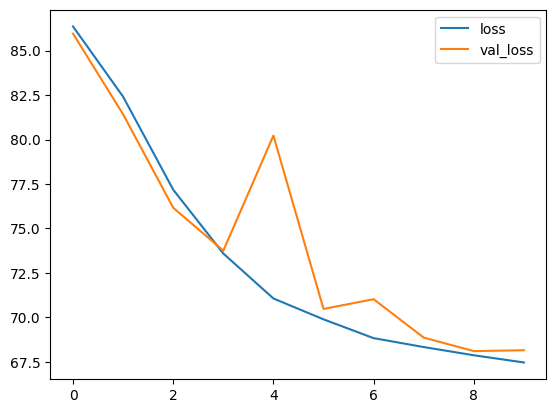

In [49]:
# How did we do?
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

In [50]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

#you might want to give your model an understandable filename
save_model(encoder,'encoder_mnist')
save_model(decoder,'decoder_mnist')
#save_model(encoder,'encoder_draw_10ep')
#save_model(decoder,'decoder_draw_10ep')

## **Let we use it**

In [55]:
# We can carry these files (*.h5, *.json) somewhere else ...
from keras.models import load_model
from keras.models import model_from_json
import json
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

#Use same filename as above here
decoder = my_load_model('decoder_mnist')
encoder = my_load_model('encoder_mnist')
#decoder = my_load_model('decoder_draw_10ep')
#encoder = my_load_model('encoder_draw_10ep')

(28, 28)
0.99607843 0.19215687 0.65153563


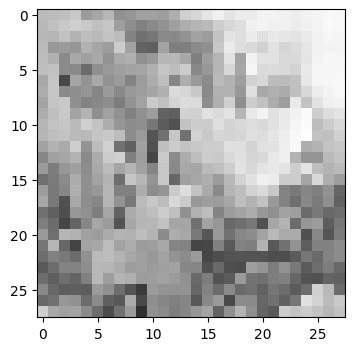

In [63]:
# Encoded image:

x1 = x_test[73] # number 73 picked for no reason at all
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

#img = x1[:,:,0]
img = x1[:,:]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

1/1 [==============================] - 0s 290ms/step
(1, 32)
3.0734315 -3.2516973 -0.072960906


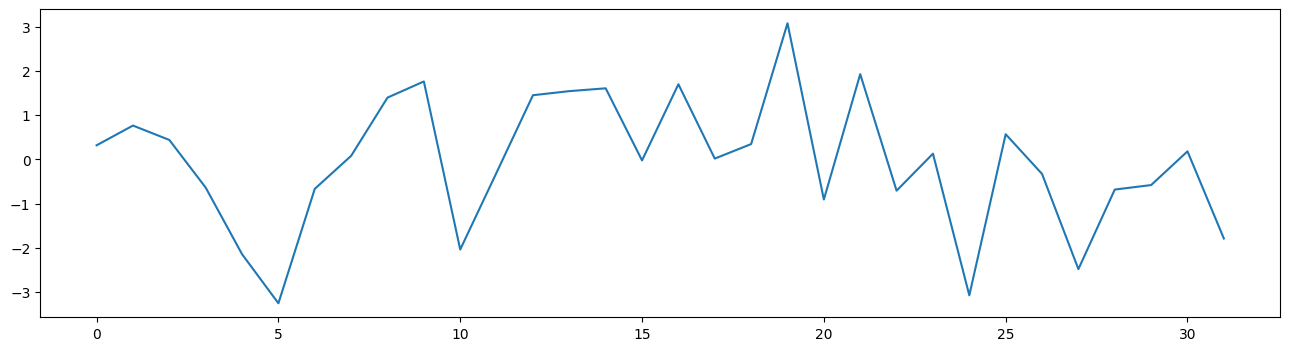

In [58]:
# Latent vector:

x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

#Plotting is not particularly informative here, it's just a set of 32 numbers, but why not?

1/1 [==============================] - 0s 25ms/step
(1, 28, 28, 1)


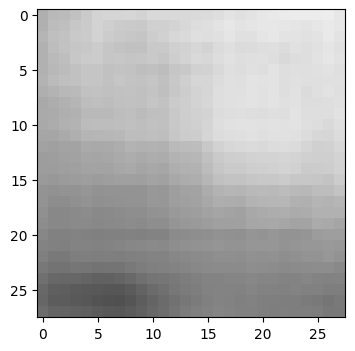

In [60]:
# Reconstructed image

y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

#img = y1[:,:,0]
img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()


### **Or in triplets:**

In [64]:
def plot_tripple(image, vector, reconstruction):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Image > Representation > Reconstruction')
    ax1.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    ax2.plot(vector)
    ax2.set_aspect(3.1)
    ax3.imshow(reconstruction, cmap='gray', vmin=0.0, vmax=1.0)

def plot_single(image):
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)

1/1 [==============================] - 0s 29ms/step


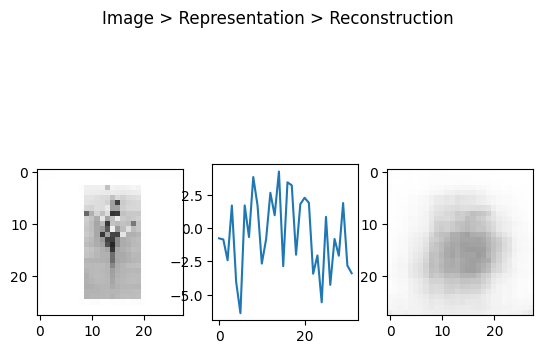

In [66]:
x1 = x_test[9] # Randomly pick 9th image from test set
z, z_mean, z_log_var = encoder.predict(np.asarray([x1])) 
y1 = decoder.predict(z)

#plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])
plot_tripple(x1[:,:], z[0], y1[0,:,:,0])